In [304]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn

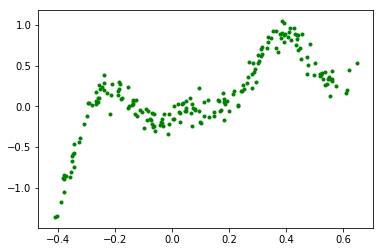

In [431]:
x = np.linspace(0,1,200)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(x, y, marker='.', color='g')

In [432]:
x.shape

(200,)

In [474]:
n_breaks = 6
parmx = list(np.sort(np.random.uniform(x.min(), x.max(), size=(n_breaks-2))))
parmx = np.array([x.min()-0.2]+parmx+[x.max()+0.2])
parmy = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks)))
print(parmx)
print(parmy)

[-0.61189266 -0.18214358  0.12325253  0.26737343  0.33419208  0.8479811 ]
[-1.0483035  -1.03955054 -0.93175035 -0.44024164 -0.39286393 -0.00989768]


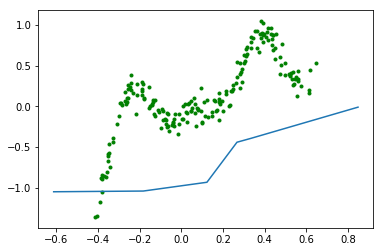

In [475]:
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)

In [476]:
def inrange(X, break0, break1): #if x is after
    xmsk1 = X >= break0
    xmsk2 = X < break1
    xmsk = np.bitwise_and(xmsk1, xmsk2)
    xs = xmsk #*X
    return xs

In [477]:
inrange(x[:30], parmx[0], parmx[1])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [478]:
def linear_interpolation(X, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros_like(X)
    for i in range(n-1):
        mask = inrange(X, break_x[i], break_x[i+1])
        Y_ = (y[i+1] - y[i])/(x[i+1] - x[i])*(X - x[i]) + y[i]
        Y = Y + Y_*mask
    return Y

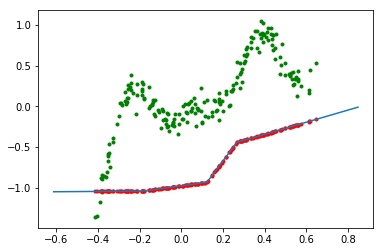

In [479]:
Y = linear_interpolation(x, parmx, parmy)
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)
plt.scatter(x, Y, marker='.', color='r')

In [480]:
dy = Y-y
error = (dy**2).mean()
print(error)

0.8523220838317329


In [481]:
def backward(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, break_x[i], break_x[i+1])
            
    for i in range(n-1):
        consts[i] = ((X-x[i])/(x[i+1] - x[i]))
    
    Y[0] = (-1* consts[0] +1)*inrange(X, break_x[0], break_x[1])
    Y[-1] = consts[-1]*inrange(X, break_x[-2], break_x[-1])
    for i in range(1, n-1):
            a = consts[i-1]*inranges[i]
            b = (-1* consts[i] +1)*inranges[i]
            Y[i] = a+b
    Y = Y*dY
    ny = np.count_nonzero(inranges, axis=1)
    Y = Y.mean(axis=1)
    return Y

In [482]:
x.shape

(200,)

In [483]:
dparmy = backward(x, dy, parmx, parmy)
dparmy

array([-0.02871813, -0.51463223, -0.15797191, -0.13172992, -0.86452744,
       -0.0536076 ])

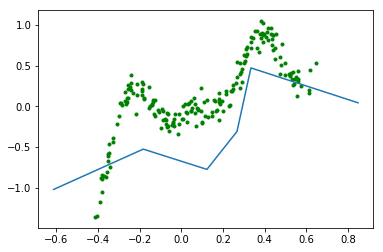

In [484]:
parmy = parmy - dparmy
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)

parmy [-1.44126078 -0.02247671 -0.12827278  0.25761794  0.87598503 -0.14987583]
error= 0.038497512651162254
dparmy [ 0.00073672  0.00041401 -0.00041707  0.00045906 -0.0006009   0.00136243]


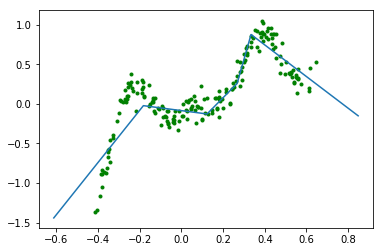

In [600]:
print('parmy',parmy)
Y = linear_interpolation(x, parmx, parmy)
dy = Y-y
error = (dy**2).mean()
print('error=',error)
dparmy = backward(x, dy, parmx, parmy)
print('dparmy',dparmy)
parmy = parmy - dparmy
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)

In [601]:
parmx

array([-0.61189266, -0.18214358,  0.12325253,  0.26737343,  0.33419208,
        0.8479811 ])

In [602]:
# now backward_for_x

In [397]:
def backward2(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(x)
    XX = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, x[i], x[i+1])
            
    for i in range(n-1):
        consts[i] = ((y[i+1]-y[i])/(x[i+1] - x[i])**2)
    
    XX[0] = consts[0]*(X - x[1])*inrange(X, x[0], x[1])
    XX[-1] = -1*consts[-1]*(X - x[-2])*inrange(X, x[-2], x[-1])
#     XX[-1] = consts[-1]*inrange(X, x[-2], x[-1])
    for i in range(1, n-1):
            a = -1*consts[i-1]*(X - x[i-1])*inranges[i]
            b = consts[i]*(X - x[i+1])*inranges[i]
            XX[i] = a+b
    XX = XX*dY
#     nx = np.count_nonzero(inranges, axis=1)
    XX = XX.mean(axis=1)
    return XX

In [398]:
dparmx = backward2(x, dy, parmx, parmy)
dparmx

array([-4.20926562e-01,  7.70740853e-01,  1.66195050e+00,  2.96479076e-01,
        1.26314243e-03, -5.11040313e-04])

In [430]:
print('parmx',parmx)
Y = linear_interpolation(x, parmx, parmy)
dy = Y-y
error = (dy**2).mean()
print('error=',error)
dparmx = backward2(x, dy, parmx, parmy)
print('dparmx',dparmx)
parmx = parmx - dparmx
parmx = np.sort(parmx)
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)

parmx None


TypeError: object of type 'NoneType' has no len()